# Testing the conditional layer without MAML

In [1]:
#import learn2learn as l2l
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import sys
import matplotlib.pyplot as plt
from collections import OrderedDict
from meta_base_models import LinearModel, Task
from multimodallearner import MultimodalLearner

sys.path.insert(1, "..")

from ts_dataset import TSDataset
from base_models import LSTMModel, FCN
from metrics import torch_mae as mae
from pytorchtools import EarlyStopping, to_torch

In [2]:

dataset_name = "HR"
dataset_name = "POLLUTION"
window_size = 32
window_size = 5
task_size = 50
batch_size = 64
input_dim = 13
input_dim = 14
output_dim = 1
hidden_dim = 120


In [3]:
train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )

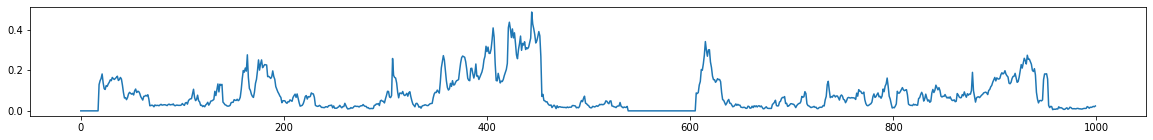

In [16]:
plt.figure(figsize = (20,2))
plt.plot(train_data.y[:1000])

In [4]:

class MetaLearner(object):
    def __init__(self, model, optimizer, fast_lr, loss_func,
                 first_order, num_updates, inner_loop_grad_clip,
                 device):

        self._model = model
        self._fast_lr = fast_lr
        self._optimizer = optimizer
        self._loss_func = loss_func
        self._first_order = first_order
        self._num_updates = num_updates
        self._inner_loop_grad_clip = inner_loop_grad_clip
        self._device = device
        self._grads_mean = []

        self.to(device)


    def update_params(self, loss, params):
        """Apply one step of gradient descent on the loss function `loss`,
        with step-size `self._fast_lr`, and returns the updated parameters.
        """
        create_graph = not self._first_order
        grads = torch.autograd.grad(loss, params.values(),
                                    create_graph=create_graph, allow_unused=True)
        for (name, param), grad in zip(params.items(), grads):
            if self._inner_loop_grad_clip > 0 and grad is not None:
                grad = grad.clamp(min=-self._inner_loop_grad_clip,
                                  max=self._inner_loop_grad_clip)
            if grad is not None:
              params[name] = param - self._fast_lr * grad

        return params

    def adapt(self, train_tasks):
        adapted_params = []

        for task in train_tasks:
            params = self._model.param_dict

            for i in range(self._num_updates):
                preds = self._model(task.x, params=params)
                loss = self._loss_func(preds, task.y)
                params = self.update_params(loss, params=params)

            adapted_params.append(params)

        return adapted_params

    def step(self, adapted_params_list, val_tasks,
             is_training, additional_loss_term = 0.0):
        
        self._optimizer.zero_grad()
        post_update_losses = []

        for adapted_params, task in zip(
                adapted_params_list, val_tasks):
            preds = self._model(task.x, params=adapted_params)

            if ~is_training:
                preds = torch.clamp(preds, 0, 1)
                loss = mae(preds, task.y)
            else:

                loss = self._loss_func(preds, task.y)
            post_update_losses.append(loss)

        mean_loss = torch.mean(torch.stack(post_update_losses)) + additional_loss_term
        if is_training:
            mean_loss.backward()
            self._optimizer.step()


        return mean_loss

    def to(self, device, **kwargs):
        self._device = device
        self._model.to(device, **kwargs)

    def state_dict(self):
        state = {
            'model_state_dict': self._model.state_dict(),
            'optimizer': self._optimizer.state_dict() 
        }

        return state

    def load_state_dict(self, state_dict):

        self._model.load_state_dict(state_dict["model_state_dict"])
        self._optimizer.load_state_dict(state_dict["optimizer"])


In [38]:
def get_task_encoder_input(data_ML):
    
    task_encoder_input = np.concatenate((data_ML.x[:,:,0,:], data_ML.y), axis=2)
    
    return task_encoder_input


   
class LSTMDecoder(nn.Module):
    
    def __init__(self, batch_size, seq_len, output_dim, n_layers, hidden_dim, latent_dim, device):
        
        super(LSTMDecoder, self).__init__()
        
        self.batch_size = batch_size
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.sequence_length = seq_len
        
        self.lstm = nn.LSTM(1, hidden_dim, n_layers, batch_first=True)
        
        self.latent_to_hidden = nn.Linear(self.latent_dim, self.hidden_dim)
        self.hidden_to_output = nn.Linear(self.hidden_dim, self.output_dim)
        
    
        self.decoder_inputs = torch.zeros( self.batch_size, self.sequence_length, 1, requires_grad=True).to(device)
        self.c_0 = torch.zeros(self.n_layers, self.batch_size, self.hidden_dim, requires_grad=True).to(device)

        nn.init.xavier_uniform_(self.latent_to_hidden.weight)
        nn.init.xavier_uniform_(self.hidden_to_output.weight)
        
        self.to(device)
        
        
    def forward(self, latent):
        
        h_state = self.latent_to_hidden(latent).unsqueeze(0)
        h_0 = torch.cat([h_state for _ in range(self.n_layers)], axis=0)
        decoder_output, _ = self.lstm(self.decoder_inputs, (h_0, self.c_0))
        out = self.hidden_to_output(decoder_output)
        
        return out
    



class Lambda(nn.Module):

    """Lambda module converts output of encoder to latent vector

    :param hidden_size: hidden size of the encoder
    :param latent_length: latent vector length
    https://github.com/abhmalik/timeseries-clustering-vae/blob/master/vrae/vrae.py

    """

    def __init__(self, hidden_dim, latent_dim):

        super(Lambda, self).__init__()

        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.hidden_to_mean = nn.Linear(self.hidden_dim, self.latent_dim)
        self.hidden_to_logvar = nn.Linear(self.hidden_dim, self.latent_dim)

        nn.init.xavier_uniform_(self.hidden_to_mean.weight)
        nn.init.xavier_uniform_(self.hidden_to_logvar.weight)


    def forward(self, cell_output):

        """Given last hidden state of encoder, passes through a linear layer, and finds the mean and variance

        :param cell_output: last hidden state of encoder
        :return: latent vector

        """

        self.latent_mean = self.hidden_to_mean(cell_output)
        self.latent_logvar = self.hidden_to_logvar(cell_output)

        if self.training:
            std = torch.exp(0.5 * self.latent_logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(self.latent_mean)
        else:
            return self.latent_mean


In [44]:
#paramters wto increase capactiy of the model
n_layers_task_net = 2
n_layers_task_encoder = 1
n_layers_task_decoder = 1

hidden_dim_task_net = 120
hidden_dim_encoder = 120
hidden_dim_decoder = 120

#fixed values
input_dim_task_net = input_dim
input_dim_task_encoder = input_dim +1 
output_dim_task_net = 1
output_dim_task_decoder = input_dim+1

        
epochs = 1000
total_tasks = len(train_data_ML)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



task_net = LSTMModel(batch_size=batch_size, 
                       seq_len = window_size, 
                       input_dim = input_dim_task_net, 
                       n_layers = n_layers_task_net, 
                       hidden_dim = hidden_dim_task_net, 
                       output_dim = output_dim_task_net)

task_encoder = LSTMModel(batch_size=batch_size, 
                         seq_len = task_size, 
                         input_dim = input_dim_task_encoder, 
                         n_layers = n_layers_task_encoder, 
                         hidden_dim = hidden_dim_encoder, 
                         output_dim =1)

task_decoder = LSTMDecoder(batch_size = 1, 
                           n_layers = n_layers_task_decoder , 
                           seq_len = task_size, 
                           output_dim = output_dim_task_decoder, 
                           hidden_dim = hidden_dim_encoder, 
                           latent_dim = hidden_dim_decoder, 
                           device = device)

lmbd = Lambda(hidden_dim_encoder, hidden_dim_task_net)


In [45]:
def test(data_ML, multimodal_learner, meta_learner, loss_fn, task_data, horizon = 10):
    
    
    
    total_tasks = len(data_ML)
    task_size = data_ML.x.shape[-3]
    input_dim = data_ML.x.shape[-1]
    window_size = data_ML.x.shape[-2]
    output_dim = data_ML.y.shape[-1]

    accum_error = 0.0
    count = 0



    for task_id in range(0, (total_tasks-horizon-1), total_tasks//100):

        x_spt, y_spt = data_ML[task_id]
        x_qry = data_ML.x[(task_id+1):(task_id+1+horizon)].reshape(-1, window_size, input_dim)
        y_qry = data_ML.y[(task_id+1):(task_id+1+horizon)].reshape(-1, output_dim)
        task = task_data[task_id:task_id+1].cuda()
        
        x_spt, y_spt = to_torch(x_spt), to_torch(y_spt)
        x_qry = to_torch(x_qry)
        y_qry = to_torch(y_qry)
        x_spt_encod, (vrae_loss, kl_loss, rec_loss) = multimodal_learner(x_spt, task, output_encoding = True)
        x_qry_encod, (vrae_loss, kl_loss, rec_loss) = multimodal_learner(x_qry, task, output_encoding = True)

        train_task = [Task(x_spt_encod, y_spt)]
        val_task = [Task(x_qry_encod, y_qry)]

        adapted_params = meta_learner.adapt(train_task)
        mean_loss = meta_learner.step(adapted_params, val_task, is_training = 0)

        count += 1
        accum_error += mean_loss.data

    return accum_error.cpu().detach().numpy()/count

#hyperparaemters: lr, weight_vrae, number of layers     
fast_lr = 0.01
first_order = False
n_inner_iter = 1
inner_loop_grad_clip = 20
noise_level = 0.0
noise_type = "additive"
loss_func = nn.SmoothL1Loss()
grid = [0., noise_level]

multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd)
multimodal_learner.to(device)

output_layer = LinearModel(120,1)
opt = torch.optim.Adam(list(multimodal_learner.parameters())+list(output_layer.parameters()), lr = 0.0001)

meta_learner = MetaLearner(output_layer, opt, fast_lr, loss_func, first_order, n_inner_iter, inner_loop_grad_clip, device)

task_data_train = torch.FloatTensor(get_task_encoder_input(train_data_ML))
task_data_validation = torch.FloatTensor(get_task_encoder_input(validation_data_ML))
task_data_test = torch.FloatTensor(get_task_encoder_input(test_data_ML))

loss_fn = nn.SmoothL1Loss()
#loss_fn = mae

val_loss_hist = []

for epoch in range(epochs):

    multimodal_learner.train()
    
    batch_idx = np.random.randint(0, total_tasks-1, batch_size)
        
    task =task_data_train[batch_idx].cuda()
    
    x_spt, y_spt = train_data_ML[batch_idx]
    x_qry, y_qry = train_data_ML[batch_idx+1]

    x_spt, y_spt = to_torch(x_spt), to_torch(y_spt)
    x_qry = to_torch(x_qry)
    y_qry = to_torch(y_qry)

    # data augmentation
    epsilon = grid[np.random.randint(0, len(grid))]

    if noise_type == "additive":
        y_spt = y_spt + epsilon
        y_qry = y_qry + epsilon
    else:
        y_spt = y_spt * (1 + epsilon)
        y_qry = y_qry * (1 + epsilon)

    x_spt_encodings = []
    x_qry_encodings = []
    vrae_loss_accum = 0.0
    for i in range(batch_size):
        x_spt_encoding, (vrae_loss, kl_loss, rec_loss) = multimodal_learner(x_spt[i],task[i:i+1], output_encoding = True)
        x_spt_encodings.append(x_spt_encoding)
        vrae_loss_accum += vrae_loss
        #print("accum_vrae:", vrae_loss_accum)
        #print("vrae:", vrae_loss)
        
        x_qry_encoding, (vrae_loss, kl_loss, rec_loss) = multimodal_learner(x_qry[i],task[i:i+1], output_encoding = True)
        x_qry_encodings.append(x_qry_encoding)
    
    train_tasks = [Task(x_spt_encodings[i], y_spt[i]) for i in range(x_spt.shape[0])]
    val_tasks = [Task(x_qry_encodings[i], y_qry[i]) for i in range(x_qry.shape[0])]
    
    #print(vrae_loss)

    adapted_params = meta_learner.adapt(train_tasks)
    mean_loss = meta_learner.step(adapted_params, val_tasks, is_training = True, additional_loss_term = vrae_loss_accum/batch_size) 
  
    
    multimodal_learner.eval()
    #with torch.no_grad():
    val_loss = test(validation_data_ML, multimodal_learner, meta_learner, mae, task_data_validation)
    test_loss = test(test_data_ML, multimodal_learner, meta_learner, mae, task_data_test)
    
    print("Epoch:", epoch)
    print("Train loss:",mean_loss)
    print("Val loss:", val_loss)
    print("Test loss:", test_loss)
    
    val_loss_hist.append(val_loss)

Epoch: 0
Train loss: tensor(0.3571, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04959866144124744
Test loss: 0.07192292991949588
Epoch: 1
Train loss: tensor(0.3490, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.048485380931965354
Test loss: 0.07084188655931123
Epoch: 2
Train loss: tensor(0.3516, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04733553210508476
Test loss: 0.06958973164461096
Epoch: 3
Train loss: tensor(0.3247, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04619870602505878
Test loss: 0.06828390335550114
Epoch: 4
Train loss: tensor(0.3611, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04516291849821517
Test loss: 0.06709352804689991
Epoch: 5
Train loss: tensor(0.3616, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.044268455320191614
Test loss: 0.06602626430745027
Epoch: 6
Train loss: tensor(0.3547, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04368537606544865
Test loss: 0.06512917791094099
Epoch: 7
Train loss: tensor(0.34

Train loss: tensor(0.3018, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.030384179457877445
Test loss: 0.04254540618585081
Epoch: 118
Train loss: tensor(0.3083, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03043111782629513
Test loss: 0.04258933845831423
Epoch: 119
Train loss: tensor(0.3114, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03052745976494354
Test loss: 0.04265752617193728
Epoch: 120
Train loss: tensor(0.3027, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.030558757411623463
Test loss: 0.04267499884780573
Epoch: 121
Train loss: tensor(0.3070, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03069851699384671
Test loss: 0.04275157500286492
Epoch: 122
Train loss: tensor(0.3402, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.030914174700246273
Test loss: 0.04288922523965641
Epoch: 123
Train loss: tensor(0.3155, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03104939044100567
Test loss: 0.04296903220974669
Epoch: 124
Train loss: tenso

KeyboardInterrupt: 

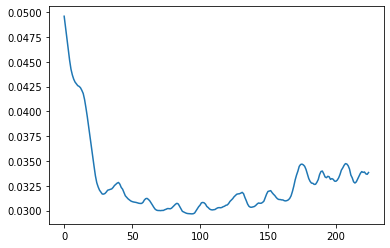

In [46]:
plt.plot(val_loss_hist)

In [9]:
batch_size

64

In [11]:
vrae_loss_accum

tensor(17.8550, device='cuda:0', grad_fn=<AddBackward0>)